# Trabajo práctico nº 1

## Paquetes utilizados y otras configuraciones

In [ ]:
# Paquetes empleados

import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # para manipular etiquetas de eje
import seaborn as sns

from scipy.stats import ttest_ind # prueba t de student



In [4]:
# Ajustar tamaño de fuente global de gráficos

plt.rcParams.update({'font.size': 14})  # tamaño base de texto

## Parte I

### Carga y análisis preliminar de datos

In [ ]:
# =========================
# RUTAS
# =========================
ruta_dta  = r"C:\Users\AGUSTIN\Desktop\Individual_t105.dta"      # 2005
ruta_xlsx = r"C:\Users\AGUSTIN\Desktop\usu_individual_T125.xlsx" # 2025

# =========================
# CARGA
# =========================
base_2005 = pd.read_stata(ruta_dta)
base_2025 = pd.read_excel(ruta_xlsx)

# =========================
# FILTRAR REGIÓN
# =========================
def sin_acentos(x):
    if pd.isna(x): return x
    return ''.join(c for c in unicodedata.normalize("NFKD", str(x)) if not unicodedata.combining(c))

# 2005: texto "Patagónica"
if "region" in base_2005.columns:
    rtxt = base_2005["region"].astype(str).map(sin_acentos).str.lower()
    base_2005 = base_2005[rtxt == "patagonica"]

# 2025: código 44
if "REGION" in base_2025.columns:
    base_2025 = base_2025[base_2025["REGION"] == 44]

# =========================
# QUEDARNOS CON VARIABLES
# =========================
vars_keep = [
    "CODUSU","NRO_HOGAR","COMPONENTE","H15","ANO4","TRIMESTRE","REGION","PONDERA",
    "CH04","CH06","CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC","IPCF",
    "CH15","PP02H","PP02I","PP10A","T_VI","ITF","PP02E"
]

# Normalizo nombres a mayúsculas
base_2005.columns = [c.upper() for c in base_2005.columns]
base_2025.columns = [c.upper() for c in base_2025.columns]

# Filtro columnas disponibles en cada base
base_2005 = base_2005[[c for c in vars_keep if c in base_2005.columns]]
base_2025 = base_2025[[c for c in vars_keep if c in base_2025.columns]]

# =========================
# ESTADÍSTICAS RÁPIDAS (ANTES DE RECODIFICAR)
# =========================
print("=== 2005: head y tipos ===")
print(base_2005.shape)
print(base_2005.head())
print(base_2005.dtypes)

print("\n=== 2025: head y tipos ===")
print(base_2025.shape)
print(base_2025.head())
print(base_2025.dtypes)

print("\n=== ESTADÍSTICAS 2005 (ANTES) ===")
for col in base_2005.columns:
    s = base_2005[col]
    print(f"\n-- {col} ({s.dtype}) --")
    if str(s.dtype) in ["int64","float64","Int64"]:
        print(s.describe())
    else:
        print(s.astype(str).value_counts(dropna=False).head(20))

print("\n=== ESTADÍSTICAS 2025 (ANTES) ===")
for col in base_2025.columns:
    s = base_2025[col]
    print(f"\n-- {col} ({s.dtype}) --")
    if str(s.dtype) in ["int64","float64","Int64"]:
        print(s.describe())
    else:
        print(s.astype(str).value_counts(dropna=False).head(20))

=== 2005: head y tipos ===
(3229, 23)
         CODUSU  NRO_HOGAR COMPONENTE  H15    ANO4       TRIMESTRE  \
43801  125814          1.0        1.0   Sí  2005.0  1er. Trimestre   
43802  125814          1.0        2.0   Sí  2005.0  1er. Trimestre   
43803  125814          1.0        3.0   Sí  2005.0  1er. Trimestre   
43804  125814          1.0        4.0  0.0  2005.0  1er. Trimestre   
43805  125814          1.0        5.0  0.0  2005.0  1er. Trimestre   

           REGION  PONDERA   CH04  CH06  ...            ESTADO  \
43801  Patagónica    249.0  Varón  46.0  ...           Ocupado   
43802  Patagónica    249.0  Mujer  32.0  ...          Inactivo   
43803  Patagónica    249.0  Varón  14.0  ...          Inactivo   
43804  Patagónica    249.0  Varón   9.0  ...  Menor de 10 años   
43805  Patagónica    249.0  Mujer   3.0  ...  Menor de 10 años   

              CAT_INAC   IPCF                             CH15 PP02H  PP02I  \
43801              0.0  480.0  En otra provincia (especificar)   

In [132]:
# =========================
# RECODIFICAR 2005 A CÓDIGOS
# =========================

# CH04 (sexo) 1=Varón, 2=Mujer
if "CH04" in base_2005.columns:
    base_2005["CH04"] = base_2005["CH04"].replace({"Varón": 1, "Mujer": 2})
    base_2005["CH04"] = pd.to_numeric(base_2005["CH04"], errors="coerce").astype("Int64")

# CH07 (estado civil) 1=Unido, 2=Casado, 3=Separado/Divorciado, 4=Viudo, 5=Soltero
if "CH07" in base_2005.columns:
    base_2005["CH07"] = base_2005["CH07"].replace({
        "Unido": 1, "Casado": 2, "Separado o divorciado": 3, "Viudo": 4, "Soltero": 5
    }).astype("Int64")

# CH08 (cobertura) 1 OS; 2 Prepaga; 3 Planes; 4 No paga; 12 OS+Prepaga; 13 OS+Planes; 9 Ns/Nr
if "CH08" in base_2005.columns:
    base_2005["CH08"] = base_2005["CH08"].replace({
        "Obra social (incluye PAMI)": 1,
        "Mutual/Prepaga/Servicio de emergencia": 2,
        "Planes y seguros públicos": 3,
        "No paga ni le descuentan": 4,
        "Obra social y mutual/prepaga/servicio de emergencia": 12,
        "Obra social y planes y seguros públicos": 13,
        "Ns./Nr.": 9
    })
    base_2005["CH08"] = pd.to_numeric(base_2005["CH08"], errors="coerce").astype("Int64")

# NIVEL_ED (nivel educativo)
# 1 Prim Incomp; 2 Prim Comp; 3 Sec Incomp; 4 Sec Comp; 5 Sup Univ Incomp; 6 Sup Univ Comp; 7 Sin instr; 9 Ns/Nr
if "NIVEL_ED" in base_2005.columns:
    base_2005["NIVEL_ED"] = base_2005["NIVEL_ED"].replace({
        "Primaria Incompleta (incluye educación especial)": 1,
        "Primaria Completa": 2,
        "Secundaria Incompleta": 3,
        "Secundaria Completa": 4,
        "Superior Universitaria Incompleta": 5,
        "Superior Universitaria Completa": 6,
        "Sin instrucción": 7,
        "Ns./Nr.": 9
    }).astype("Int64")

# ESTADO (0 Entrevista no realizada; 1 Ocupado; 2 Desocupado; 3 Inactivo; 4 Menor de 10 años)
if "ESTADO" in base_2005.columns:
    s = base_2005["ESTADO"].astype(str).str.strip()

    # Mapas directos
    s = s.replace({
        "Ocupado": "1",
        "Desocupado": "2",
        "Inactivo": "3",
    })

    # Coincidencias parciales (por si viene el texto largo o variantes)
    s = s.replace({
        r"^Menor de 10.*": "4",
        r"^Entrevista individual no realizada.*": "0"
    }, regex=True)

    # Pasar a numérico de forma segura
    base_2005["ESTADO"] = pd.to_numeric(s, errors="coerce").astype("Int64")

    # (Opcional) Ver qué quedó sin mapear
    no_map = s[~s.isin(["0","1","2","3","4"])].unique().tolist()
    if len(no_map) > 0:
        print("⚠️ ESTADO con valores no mapeados:", no_map[:10])

# CAT_INAC (inactividad) 0 No corresponde; 1 Jubilado; 2 Rentista; 3 Estudiante; 4 Ama de casa; 5 Menor 6; 6 Discap.; 7 Otros
if "CAT_INAC" in base_2005.columns:
    base_2005["CAT_INAC"] = base_2005["CAT_INAC"].replace({
        "0.0": 0,
        "Jubilado/pensionado": 1,
        "Rentista": 2,
        "Estudiante": 3,
        "Ama de casa": 4,
        "Menor de 6 años": 5,
        "Discapacitado": 6,
        "Otros": 7
    })
    base_2005["CAT_INAC"] = pd.to_numeric(base_2005["CAT_INAC"], errors="coerce").astype("Int64")

# CH15 (lugar de nacimiento) 1 Esta loc.; 2 Otra loc.; 3 Otra prov.; 4 País limítrofe; 5 Otro país; 9 Ns/Nr
if "CH15" in base_2005.columns:
    base_2005["CH15"] = base_2005["CH15"].replace({
        "En esta localidad": 1,
        "En otra localidad": 2,
        "En otra provincia (especificar)": 3,
        "En un país limítrofe": 4,
        "En otro país": 5
    }).astype("Int64")

# PP02E: mapear textos a códigos y mantener los 0
mapping_pp02e = {
    "Está suspendido": 1,
    "Ya tiene trabajo asegurado": 2,
    "Se cansó de buscar trabajo": 3,
    "Hay poco trabajo en esta época del año": 4,
    "Por otras razones": 5
}

base_2005["PP02E"] = base_2005["PP02E"].astype(object)
base_2005["PP02E"] = base_2005["PP02E"].replace(mapping_pp02e)
base_2005["PP02E"] = pd.to_numeric(base_2005["PP02E"], errors="coerce").fillna(0).astype("int64")

# PP02H / PP02I (1 Sí, 2 No, 0 No corresponde)
if "PP02H" in base_2005.columns:
    base_2005["PP02H"] = base_2005["PP02H"].replace({"Sí": 1, "No": 2, "0.0": 0}).astype("Int64")
if "PP02I" in base_2005.columns:
    base_2005["PP02I"] = base_2005["PP02I"].replace({"Sí": 1, "No": 2, "0.0": 0}).astype("Int64")

# PP10A (antigüedad de búsqueda)
# 1 <1m; 2 1-3m; 3 3-6m; 4 6-12m; 5 >1a; NaN = no corresponde

# PP10A (antigüedad de búsqueda)
# 1 <1m; 2 1-3m; 3 3-6m; 4 6-12m; 5 >1a
# 0 / "0" / "0.0" -> vacíos (NaN)

if "PP10A" in base_2005.columns:
    s = base_2005["PP10A"].astype(object)  # romper categorical

    s = s.replace({
        "...menos de 1 mes?": 1,
        "...de 1 a 3 meses?": 2,
        "...más de 3 a 6 meses?": 3,
        "...más de 6 a 12 meses?": 4,
        "...más de 1 año?": 5,
        "0": np.nan,
        "0.0": np.nan,
        0: np.nan
    })

    # convertir a numérico dejando vacíos como NaN
    base_2005["PP10A"] = pd.to_numeric(s, errors="coerce").astype("float64")
    
# TRIMESTRE y REGION (códigos)
if "TRIMESTRE" in base_2005.columns:
    base_2005["TRIMESTRE"] = base_2005["TRIMESTRE"].replace({"1er. Trimestre": 1}).astype("Int64")
if "REGION" in base_2005.columns:
    base_2005["REGION"] = 44

# H15 (sí/no)
if "H15" in base_2005.columns:
    base_2005["H15"] = base_2005["H15"].replace({"Sí": 1, "No": 0, "0.0": 0}).astype("Int64")

# Conversión simple para numéricas comunes
for c in ["CH06","NRO_HOGAR","COMPONENTE","ANO4","PONDERA","ITF","T_VI","IPCF","PP02E"]:
    if c in base_2005.columns:
        base_2005[c] = pd.to_numeric(base_2005[c], errors="coerce")

# =========================
# ESTADÍSTICAS RÁPIDAS (DESPUÉS DE RECODIFICAR 2005)
# =========================
print("\n=== 2005: tipos DESPUÉS de recodificar ===")
print(base_2005.dtypes)

print("\n=== 2005: frecuencias rápidas de variables recodificadas ===")
for c in ["CH04", "CH06", "CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC","CH15", "PP02E","PP02H","PP02I","PP10A","TRIMESTRE","REGION","H15"]:
    if c in base_2005.columns:
        print(f"\n{c}")
        print(base_2005[c].value_counts(dropna=False).head(15))


=== 2005: tipos DESPUÉS de recodificar ===
CODUSU         object
NRO_HOGAR     float64
COMPONENTE    float64
H15             Int64
ANO4          float64
TRIMESTRE       Int64
REGION          int64
PONDERA       float64
CH04            Int64
CH06          float64
CH07            Int64
CH08            Int64
NIVEL_ED        Int64
ESTADO          Int64
CAT_INAC        Int64
IPCF          float64
CH15            Int64
PP02H           Int64
PP02I           Int64
PP10A         float64
T_VI          float64
ITF           float64
PP02E           int64
dtype: object

=== 2005: frecuencias rápidas de variables recodificadas ===

CH04
CH04
2       1654
1       1575
<NA>       0
Name: count, dtype: Int64

CH06
CH06
17.0    86
15.0    78
13.0    74
10.0    73
12.0    70
7.0     70
14.0    70
9.0     68
6.0     67
11.0    66
27.0    63
5.0     63
4.0     60
18.0    60
NaN     57
Name: count, dtype: int64

CH07
CH07
5       1678
2        911
1        381
3        152
4        107
<NA>       0
Name: c

In [134]:
# =========================
# Comparar tipos de 2005 vs 2025
# =========================
comunes = sorted(set(base_2005.columns) & set(base_2025.columns))

dtypes_2005 = base_2005[comunes].dtypes.astype(str)
dtypes_2025 = base_2025[comunes].dtypes.astype(str)

comp = pd.DataFrame({
    "dtype_2005": dtypes_2005,
    "dtype_2025": dtypes_2025
})
comp["Coincide"] = comp["dtype_2005"] == comp["dtype_2025"]

print("=== Comparación de dtypes (columnas comunes) ===")
print(comp)

=== Comparación de dtypes (columnas comunes) ===
           dtype_2005 dtype_2025  Coincide
ANO4          float64      int64     False
CAT_INAC        Int64      int64     False
CH04            Int64      int64     False
CH06          float64      int64     False
CH07            Int64      int64     False
CH08            Int64    float64     False
CH15            Int64      int64     False
CODUSU         object     object      True
COMPONENTE    float64      int64     False
ESTADO          Int64      int64     False
H15             Int64      int64     False
IPCF          float64    float64      True
ITF           float64      int64     False
NIVEL_ED        Int64      int64     False
NRO_HOGAR     float64      int64     False
PONDERA       float64      int64     False
PP02E           int64      int64      True
PP02H           Int64      int64     False
PP02I           Int64      int64     False
PP10A         float64    float64      True
REGION          int64      int64      True
TRIME

In [136]:
# =========================
# Forzar dtypes 2005 = 2025
# =========================

# Estas deben ser int64 como en 2025
to_int64 = [
    "ANO4","CAT_INAC","CH04","CH06","CH07","CH15","COMPONENTE","ESTADO","H15",
    "ITF","NIVEL_ED","NRO_HOGAR","PONDERA","PP02E","PP02H","PP02I","TRIMESTRE","T_VI"
]

# Estas deben ser float64 como en 2025
to_float64 = ["CH08"] 

for c in to_int64:
    if c in base_2005.columns:
        s = pd.to_numeric(base_2005[c], errors="coerce")   # a número
        s = s.fillna(0).round()                            # resolvé NaN y redondeá
        base_2005[c] = s.astype("int64")                   # cast final

for c in to_float64:
    if c in base_2005.columns:
        base_2005[c] = pd.to_numeric(base_2005[c], errors="coerce").astype("float64")

# =========================
# Re-chequear coincidencia
# =========================
comunes = sorted(set(base_2005.columns) & set(base_2025.columns))
comp = (
    pd.DataFrame({
        "dtype_2005": base_2005[comunes].dtypes.astype(str),
        "dtype_2025": base_2025[comunes].dtypes.astype(str)
    })
)
comp["Coincide"] = comp["dtype_2005"] == comp["dtype_2025"]

print("=== Comparación de dtypes (columnas comunes) ===")
print(comp)
print("\n=== No coinciden ===")
print(comp[~comp["Coincide"]])

# =========================
# GUARDAR BASES
# =========================
out_dir = r"C:\Users\AGUSTIN\Desktop"

base_2005.to_excel(fr"{out_dir}\basei_05.xlsx", index=False)
base_2025.to_excel(fr"{out_dir}\basei_25.xlsx", index=False)

print("Listo.")

=== Comparación de dtypes (columnas comunes) ===
           dtype_2005 dtype_2025  Coincide
ANO4            int64      int64      True
CAT_INAC        int64      int64      True
CH04            int64      int64      True
CH06            int64      int64      True
CH07            int64      int64      True
CH08          float64    float64      True
CH15            int64      int64      True
CODUSU         object     object      True
COMPONENTE      int64      int64      True
ESTADO          int64      int64      True
H15             int64      int64      True
IPCF          float64    float64      True
ITF             int64      int64      True
NIVEL_ED        int64      int64      True
NRO_HOGAR       int64      int64      True
PONDERA         int64      int64      True
PP02E           int64      int64      True
PP02H           int64      int64      True
PP02I           int64      int64      True
PP10A         float64    float64      True
REGION          int64      int64      True
TRIME

In [138]:
# =========================
# UNIR AMBAS BASES
# =========================

# 1) Columna de período (AÑO + TRIMESTRE)
base_2005["PERIODO"] = base_2005["ANO4"].astype("string") + "T" + base_2005["TRIMESTRE"].astype("string")
base_2025["PERIODO"] = base_2025["ANO4"].astype("string") + "T" + base_2025["TRIMESTRE"].astype("string")

# 2) Usamos el orden de columnas de 2025 como "estándar"
cols_std = list(base_2025.columns)

# Por si a 2005 le falta alguna col
for c in cols_std:
    if c not in base_2005.columns:
        base_2005[c] = pd.NA

# Reordenamos igual en ambas
base_2005 = base_2005[cols_std]
base_2025 = base_2025[cols_std]

# 3) Concatenamos (apilamos)
base_unida = pd.concat([base_2005, base_2025], ignore_index=True)

# 4) Vista rápida
print("Base unida → shape:", base_unida.shape)
print(base_unida.head())
print(base_unida.dtypes)

# 5) Guardar
out_dir = r"C:\Users\AGUSTIN\Desktop"
base_unida.to_excel(fr"{out_dir}\basei_unida.xlsx", index=False)
print(fr"✅ Guardado: {out_dir}\basei_unida.xlsx")


Base unida → shape: (8588, 24)
     CODUSU  NRO_HOGAR  COMPONENTE  H15  ANO4  TRIMESTRE  REGION  PONDERA  \
0  125814            1           1    1  2005          1      44      249   
1  125814            1           2    1  2005          1      44      249   
2  125814            1           3    1  2005          1      44      249   
3  125814            1           4    0  2005          1      44      249   
4  125814            1           5    0  2005          1      44      249   

   CH04  CH06  ...  CAT_INAC   IPCF  CH15  PP02H  PP02I  PP10A  T_VI   ITF  \
0     1    46  ...         0  480.0     3      0      0    NaN     0  2400   
1     2    32  ...         4  480.0     3      2      2    NaN     0  2400   
2     1    14  ...         3  480.0     3      2      2    NaN     0  2400   
3     1     9  ...         3  480.0     1      0      0    NaN     0  2400   
4     2     3  ...         5  480.0     1      0      0    NaN     0  2400   

   PP02E  PERIODO  
0      0   2005T1

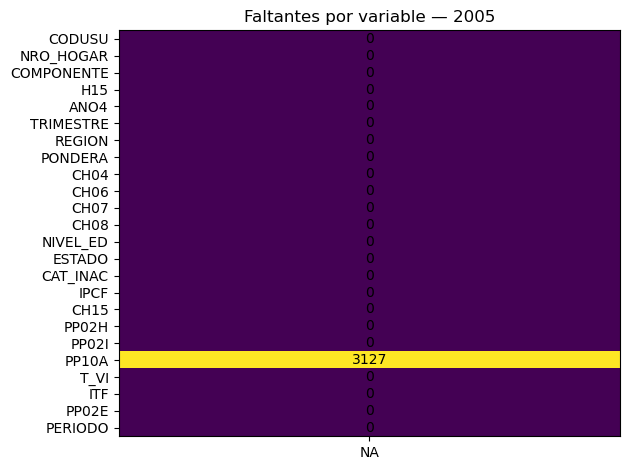

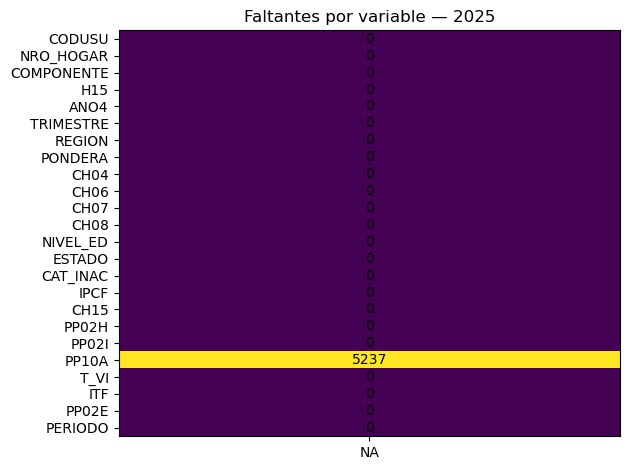

In [140]:
# =========================
# HEATMAP
# =========================
def heatmap_na(df, titulo):
    # Cantidad de faltantes por columna
    na = df.isna().sum()
    data = na.values.reshape(-1, 1)  # matriz (n_vars x 1)

    plt.figure()
    plt.imshow(data, aspect='auto')  # sin colores específicos
    plt.yticks(np.arange(len(na.index)), na.index)
    plt.xticks([0], ['NA'])
    plt.title(titulo)

    # pintar los números encima de cada celda
    for i, v in enumerate(na.values):
        plt.text(0, i, int(v), ha='center', va='center')

    plt.tight_layout()
    plt.show()

# base_unida con ANO4, hacemos un heatmap por año
if 'base_unida' in globals() and 'ANO4' in base_unida.columns:
    for year in sorted(base_unida['ANO4'].dropna().unique()):
        df_year = base_unida[base_unida['ANO4'] == year]
        heatmap_na(df_year, f'Faltantes por variable — {int(year)}')
else:
    # fallback: dos heatmaps, uno por base
    if 'base_2005' in globals():
        heatmap_na(base_2005, 'Faltantes por variable — 2005')
    if 'base_2025' in globals():
        heatmap_na(base_2025, 'Faltantes por variable — 2025')



In [142]:
# =========================
# LIMPIEZA DE VALORES SIN SENTIDO
# =========================
# Edad menor a 1 se reemplaza por 0
base_unida["CH06"] = base_unida["CH06"].replace(-1, 0)
# Se eliminan las observaciones con T_VI igual a -9
base_unida = base_unida[base_unida["T_VI"] != "-9"]

# =========================
# RESUMEN DE LA BASE
# =========================

print("=== RESUMEN GENERAL ===")
print(f"Cantidad de observaciones (filas): {base_unida.shape[0]}")
print(f"Cantidad de variables (columnas): {base_unida.shape[1]}\n")

print("=== INFORMACIÓN DE VARIABLES ===")
print(base_unida.info())

print("\n=== ESTADÍSTICAS DESCRIPTIVAS (solo numéricas) ===")
print(base_unida.describe())

=== RESUMEN GENERAL ===
Cantidad de observaciones (filas): 8588
Cantidad de variables (columnas): 24

=== INFORMACIÓN DE VARIABLES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8588 entries, 0 to 8587
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      8588 non-null   object 
 1   NRO_HOGAR   8588 non-null   int64  
 2   COMPONENTE  8588 non-null   int64  
 3   H15         8588 non-null   int64  
 4   ANO4        8588 non-null   int64  
 5   TRIMESTRE   8588 non-null   int64  
 6   REGION      8588 non-null   int64  
 7   PONDERA     8588 non-null   int64  
 8   CH04        8588 non-null   int64  
 9   CH06        8588 non-null   int64  
 10  CH07        8588 non-null   int64  
 11  CH08        8588 non-null   float64
 12  NIVEL_ED    8588 non-null   int64  
 13  ESTADO      8588 non-null   int64  
 14  CAT_INAC    8588 non-null   int64  
 15  IPCF        8588 non-null   float64
 16  CH15        858

In [144]:
# =========================
# BASE HOGARES
# =========================
hogar_dta  = r"C:\Users\AGUSTIN\Desktop\Hogar_t105.dta"      # 2005
hogar_xlsx = r"C:\Users\AGUSTIN\Desktop\usu_hogar_T125.xlsx" # 2025

# =========================
# CARGA
# =========================
hogar_2005 = pd.read_stata(hogar_dta)
hogar_2025 = pd.read_excel(hogar_xlsx)

# =========================
# FILTRAR REGIÓN
# =========================
def sin_acentos(x):
    if pd.isna(x): return x
    return ''.join(c for c in unicodedata.normalize("NFKD", str(x)) if not unicodedata.combining(c))

# 2005: texto "Patagónica/Patagonica"
if "region" in hogar_2005.columns:
    rtxt = hogar_2005["region"].astype(str).map(sin_acentos).str.lower()
    hogar_2005 = hogar_2005[rtxt == "patagonica"]

# 2025: código 44
if "REGION" in hogar_2025.columns:
    hogar_2025 = hogar_2025[hogar_2025["REGION"] == 44]

# =========================
# QUEDARNOS CON VARIABLES
# =========================
vars_keep_hogar = [
    "CODUSU","NRO_HOGAR","ANO4","TRIMESTRE","IV1","IV2","IV6","IV8","II8"
]

# Normalizo nombres a mayúsculas
hogar_2005.columns = [c.upper() for c in hogar_2005.columns]
hogar_2025.columns = [c.upper() for c in hogar_2025.columns]

# Filtro columnas disponibles en cada base
hogar_2005 = hogar_2005[[c for c in vars_keep_hogar if c in hogar_2005.columns]]
hogar_2025 = hogar_2025[[c for c in vars_keep_hogar if c in hogar_2025.columns]]

In [146]:
# =========================
# ESTADÍSTICAS Y TIPOS DE VARIABLES
# =========================

def resumen_base(df, nombre):
    print(f"\n=== {nombre} ===")
    print(f"N° de observaciones: {df.shape[0]}")
    print(f"N° de variables: {df.shape[1]}\n")

    print(">>> Tipos de variables:")
    print(df.dtypes)

    print("\n>>> Estadísticas descriptivas:")
    print(df.describe(include="all"))

# Mostrar resumen para ambas bases
resumen_base(hogar_2005, "BASE HOGAR 2005")
resumen_base(hogar_2025, "BASE HOGAR 2025")



=== BASE HOGAR 2005 ===
N° de observaciones: 950
N° de variables: 9

>>> Tipos de variables:
CODUSU         object
NRO_HOGAR     float64
ANO4          float64
TRIMESTRE    category
IV1          category
IV2          category
IV6          category
IV8          category
II8          category
dtype: object

>>> Estadísticas descriptivas:
          CODUSU   NRO_HOGAR    ANO4       TRIMESTRE   IV1    IV2  \
count        950  950.000000   950.0             950   950  950.0   
unique       949         NaN     NaN               1     4    9.0   
top     230028           NaN     NaN  1er. Trimestre  Casa    3.0   
freq           2         NaN     NaN             950   731  305.0   
mean         NaN    1.056842  2005.0             NaN   NaN    NaN   
std          NaN    0.244929     0.0             NaN   NaN    NaN   
min          NaN    1.000000  2005.0             NaN   NaN    NaN   
25%          NaN    1.000000  2005.0             NaN   NaN    NaN   
50%          NaN    1.000000  2005.0     

In [148]:
# =========================
# RECODIFICACIÓN
# =========================
# IV1
# 1 = Casa
# 2 = Departamento
# 3 = Pieza en inquilinato
# 4 = Pieza en hotel/pensión
# 5 = Local no construido para habitación

if "IV1" in hogar_2005.columns:
    hogar_2005["IV1"] = hogar_2005["IV1"].replace({
        "Casa": 1,
        "Departamento": 2,
        "Pieza en inquilinato": 3,
        "Pieza en hotel/pensión": 4,
        "Local no construido para habitación": 5
    })
    
    # Convertimos a numérico por si había strings mezclados
    hogar_2005["IV1"] = pd.to_numeric(hogar_2005["IV1"], errors="coerce").astype("Int64")

# IV6 ¿Tiene agua...
# 1 = por cañería dentro de la vivienda
# 2 = fuera de la vivienda pero dentro del terreno
# 3 = fuera del terreno

def normaliza(s):
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s

if "IV6" in hogar_2005.columns:
    hogar_2005["IV6b"] = 1  # todos empiezan con 1
    tmp = hogar_2005["IV6"].map(normaliza)

    hogar_2005.loc[tmp.str.contains("fuera de la vivienda pero dentro del terreno", na=False), "IV6b"] = 2
    hogar_2005.loc[tmp.str.contains("fuera del terreno", na=False), "IV6b"] = 3
    hogar_2005.loc[hogar_2005["IV6"].isin([0, "0"]), "IV6b"] = 0

    hogar_2005["IV6b"] = pd.to_numeric(hogar_2005["IV6b"], errors="coerce").astype("Int64")

# IV8 ¿Tiene baño/letrina?
# 1 = Sí
# 2 = No

if "IV8" in hogar_2005.columns:
    hogar_2005["IV8"] = hogar_2005["IV8"].replace({
        "Sí": 1,
        "Si": 1,   # por si viene sin tilde
        "No": 2
    })

    # Convertimos a numérico
    hogar_2005["IV8"] = pd.to_numeric(hogar_2005["IV8"], errors="coerce").astype("Int64")

# II8 ¿Para cocinar, utiliza principalmente...
# 1 = Gas de red
# 2 = Gas de tubo/garrafa
# 3 = Kerosene, leña o carbón

if "II8" in hogar_2005.columns:
    # Por defecto todo = 3
    hogar_2005["II8b"] = 3

    # Asignaciones condicionales
    hogar_2005.loc[hogar_2005["II8"] == "Gas de red", "II8b"] = 1
    hogar_2005.loc[hogar_2005["II8"] == "Gas de tubo/garrafa", "II8b"] = 2
    hogar_2005.loc[hogar_2005["II8"] == "Otro", "II8b"] = 4
    hogar_2005.loc[hogar_2005["II8"].isin([0, "0"]), "II8b"] = 0

    # Convertimos a numérico
    hogar_2005["II8b"] = pd.to_numeric(hogar_2005["II8b"], errors="coerce").astype("Int64")

    
# =========================
# ESTADISTICAS
# =========================

variables = ["IV1", "IV2", "IV6b", "IV8", "II8b"]

for var in variables:
    if var in hogar_2005.columns:
        print(f"\n======================")
        print(f"TABULACIÓN DE {var}")
        print(f"Tipo de variable: {hogar_2005[var].dtype}")
        print(f"N° de valores no nulos: {hogar_2005[var].notna().sum()}")
        print(f"N° de valores faltantes: {hogar_2005[var].isna().sum()}\n")

        print(hogar_2005[var].value_counts(dropna=False).sort_index())



TABULACIÓN DE IV1
Tipo de variable: Int64
N° de valores no nulos: 946
N° de valores faltantes: 4

IV1
1       731
2       213
4         2
<NA>      4
Name: count, dtype: Int64

TABULACIÓN DE IV2
Tipo de variable: category
N° de valores no nulos: 950
N° de valores faltantes: 0

IV2
1.0        115
2.0        167
3.0        305
4.0        226
5.0         89
6.0         32
7.0         11
8.0          4
9.0          1
10.0         0
11.0         0
12.0         0
21.0         0
31.0         0
Ns./Nr.      0
Name: count, dtype: int64

TABULACIÓN DE IV6b
Tipo de variable: Int64
N° de valores no nulos: 950
N° de valores faltantes: 0

IV6b
0         5
1       924
2        18
3         3
<NA>      0
Name: count, dtype: Int64

TABULACIÓN DE IV8
Tipo de variable: Int64
N° de valores no nulos: 950
N° de valores faltantes: 0

IV8
1       946
2         4
<NA>      0
Name: count, dtype: Int64

TABULACIÓN DE II8b
Tipo de variable: Int64
N° de valores no nulos: 950
N° de valores faltantes: 0

II8b
0    

In [150]:
# Eliminar II8 e IV6 (si existen) en 2005
hogar_2005 = hogar_2005.drop(columns=["II8", "IV6"], errors="ignore")

# Renombrar II8b -> II8 y IV6b -> IV6 (solo si existen)
rename_map = {}
if "II8b" in hogar_2005.columns:
    rename_map["II8b"] = "II8"
if "IV6b" in hogar_2005.columns:
    rename_map["IV6b"] = "IV6"

hogar_2005 = hogar_2005.rename(columns=rename_map)

# Comparar tipos de variables entre 2005 y 2025
print("=== Tipos de variables en hogar_2005 ===")
print(hogar_2005.dtypes)

print("\n=== Tipos de variables en hogar_2025 ===")
print(hogar_2025.dtypes)

# Comparación lado a lado
t2005 = hogar_2005.dtypes.astype(str)
t2025 = hogar_2025.dtypes.astype(str)
todas = sorted(set(t2005.index) | set(t2025.index))

comparacion = pd.DataFrame({
    "Tipo_2005": t2005.reindex(todas),
    "Tipo_2025": t2025.reindex(todas)
}).fillna("No existe")

print("\n=== COMPARACIÓN DE TIPOS DE VARIABLES (2005 vs 2025) ===")
print(comparacion)

# Hacemos coincidir a IV2
if "IV2" in hogar_2005.columns and "IV2" in hogar_2025.columns:
    # Convertimos a numérico (int64)
    hogar_2005["IV2"] = pd.to_numeric(hogar_2005["IV2"], errors="coerce").astype("Int64")
    hogar_2025["IV2"] = pd.to_numeric(hogar_2025["IV2"], errors="coerce").astype("Int64")

# =========================
# COMPARACIÓN ACTUALIZADA
# =========================

t2005 = hogar_2005.dtypes.astype(str)
t2025 = hogar_2025.dtypes.astype(str)
todas = sorted(set(t2005.index) | set(t2025.index))

comparacion = pd.DataFrame({
    "Tipo_2005": t2005.reindex(todas),
    "Tipo_2025": t2025.reindex(todas)
}).fillna("No existe")

print("\n=== COMPARACIÓN DE TIPOS DE VARIABLES (2005 vs 2025) ===")
print(comparacion)

# =========================
# GUARDAR BASES
# =========================
out_dir = r"C:\Users\AGUSTIN\Desktop"

hogar_2005.to_excel(fr"{out_dir}\baseh_05.xlsx", index=False)
hogar_2025.to_excel(fr"{out_dir}\baseh_25.xlsx", index=False)

print("Listo.")

=== Tipos de variables en hogar_2005 ===
CODUSU         object
NRO_HOGAR     float64
ANO4          float64
TRIMESTRE    category
IV1             Int64
IV2          category
IV8             Int64
IV6             Int64
II8             Int64
dtype: object

=== Tipos de variables en hogar_2025 ===
CODUSU       object
NRO_HOGAR     int64
ANO4          int64
TRIMESTRE     int64
IV1           int64
IV2           int64
IV6           int64
IV8           int64
II8           int64
dtype: object

=== COMPARACIÓN DE TIPOS DE VARIABLES (2005 vs 2025) ===
          Tipo_2005 Tipo_2025
ANO4        float64     int64
CODUSU       object    object
II8           Int64     int64
IV1           Int64     int64
IV2        category     int64
IV6           Int64     int64
IV8           Int64     int64
NRO_HOGAR   float64     int64
TRIMESTRE  category     int64

=== COMPARACIÓN DE TIPOS DE VARIABLES (2005 vs 2025) ===
          Tipo_2005 Tipo_2025
ANO4        float64     int64
CODUSU       object    object
II8  

In [152]:
# =========================
# UNIR HOGAR 2005 Y 2025
# =========================

# Creamos la columna PERIODO en ambas bases
hogar_2005["PERIODO"] = hogar_2005["ANO4"].astype(str) + "T" + hogar_2005["TRIMESTRE"].astype(str)
hogar_2025["PERIODO"] = hogar_2025["ANO4"].astype(str) + "T" + hogar_2025["TRIMESTRE"].astype(str)

# Usamos el orden de columnas de 2025 como referencia
cols_std = list(hogar_2025.columns)

# Agregamos a 2005 las columnas que falten
for c in cols_std:
    if c not in hogar_2005.columns:
        hogar_2005[c] = pd.NA

# Reordenamos igual
hogar_2005 = hogar_2005[cols_std]
hogar_2025 = hogar_2025[cols_std]

# Unimos (apilamos)
hogar_unida = pd.concat([hogar_2005, hogar_2025], ignore_index=True)

# Vista rápida
print("Base unida →", hogar_unida.shape)
print(hogar_unida.head())

# Guardar
hogar_unida.to_excel(r"C:\Users\AGUSTIN\Desktop\hogar_unida.xlsx", index=False)
print("✅ Archivo guardado en el escritorio")

Base unida → (3036, 10)
     CODUSU  NRO_HOGAR    ANO4       TRIMESTRE  IV1  IV2  IV6  IV8  II8  \
0  125814          1.0  2005.0  1er. Trimestre    1    4    1    1    1   
1  125969          1.0  2005.0  1er. Trimestre    1    3    1    1    1   
2  126039          1.0  2005.0  1er. Trimestre    2    2    1    1    1   
3  126757          1.0  2005.0  1er. Trimestre    2    2    1    1    1   
4  127292          1.0  2005.0  1er. Trimestre    1    4    1    1    1   

                 PERIODO  
0  2005.0T1er. Trimestre  
1  2005.0T1er. Trimestre  
2  2005.0T1er. Trimestre  
3  2005.0T1er. Trimestre  
4  2005.0T1er. Trimestre  
✅ Archivo guardado en el escritorio


In [ ]:
# =========================
# UNIÓN POR INTERSECCIÓN (INNER JOIN)
# =========================

# Aseguramos que las claves sean del mismo tipo
for df in (base_unida, hogar_unida):
    df["CODUSU"] = df["CODUSU"].astype(str)
    df["NRO_HOGAR"] = pd.to_numeric(df["NRO_HOGAR"], errors="coerce").astype("Int64")

# Claves
keys = ["CODUSU", "NRO_HOGAR"]

# Unión por intersección
union_inner = pd.merge(base_unida, hogar_unida, on=keys, how="inner", suffixes=("_ind", "_hog"))

# Reporte
print("=== UNIÓN POR INTERSECCIÓN ===")
print(f"Filas resultantes (matches): {union_inner.shape[0]}")
print(f"Columnas resultantes: {union_inner.shape[1]}")
print(f"Total de NAs: {union_inner.isna().sum().sum()}")

# Vista rápida
print("\nVista previa:")
print(union_inner.head())


=== UNIÓN POR INTERSECCIÓN ===
Filas resultantes (matches): 8588
Columnas resultantes: 32
Total de NAs: 8378

Vista previa:
     CODUSU  NRO_HOGAR  COMPONENTE  H15  ANO4_ind  TRIMESTRE_ind  REGION  \
0  125814            1           1    1      2005              1      44   
1  125814            1           2    1      2005              1      44   
2  125814            1           3    1      2005              1      44   
3  125814            1           4    0      2005              1      44   
4  125814            1           5    0      2005              1      44   

   PONDERA  CH04  CH06  ...  PP02E  PERIODO_ind  ANO4_hog   TRIMESTRE_hog  \
0      249     1    46  ...      0       2005T1    2005.0  1er. Trimestre   
1      249     2    32  ...      0       2005T1    2005.0  1er. Trimestre   
2      249     1    14  ...      0       2005T1    2005.0  1er. Trimestre   
3      249     1     9  ...      0       2005T1    2005.0  1er. Trimestre   
4      249     2     3  ...      0

In [ ]:
#Primera parte inciso d

In [2]:
df_individuos = pd.read_excel(r"C:\Users\juanc\Documents\GitHub\BigDataUBA-Grupo1\TP1\basei_unida.xlsx")
df_hogares = pd.read_excel(r"C:\Users\juanc\Documents\GitHub\BigDataUBA-Grupo1\TP1\hogar_unida.xlsx")


In [52]:
#Me aseguro de tener datos string para generar un id
df_individuos['CODUSU'] = df_individuos['CODUSU'].astype(str)
df_individuos['NRO_HOGAR'] = df_individuos['NRO_HOGAR'].astype(str)

df_hogares['CODUSU'] = df_hogares['CODUSU'].astype(str)
df_hogares['NRO_HOGAR'] = df_hogares['NRO_HOGAR'].astype(str)

In [53]:
# Crear ID único
df_individuos['id_eph'] = df_individuos['CODUSU'] + "-" + df_individuos['NRO_HOGAR']
df_hogares['id_eph'] = df_hogares['CODUSU'] + "-" + df_hogares['NRO_HOGAR']

In [55]:
#Exploro la composicion de las variables IV1, IV2, IV6, IV8 y II8

variables = ["IV1", "IV2", "IV6", "IV8", "II8"]

for var in variables:
    print(f"\n--- Frecuencia de {var} ---")
    print(df_hogares[var].value_counts(dropna=False))



--- Frecuencia de IV1 ---
IV1
1.0    2374
2.0     652
NaN       4
6.0       3
4.0       2
3.0       1
Name: count, dtype: int64

--- Frecuencia de IV2 ---
IV2
3    1021
2     741
4     637
1     316
5     226
6      64
7      22
8       8
9       1
Name: count, dtype: int64

--- Frecuencia de IV6 ---
IV6
1    3004
2      24
0       5
3       3
Name: count, dtype: int64

--- Frecuencia de IV8 ---
IV8
1    3031
2       5
Name: count, dtype: int64

--- Frecuencia de II8 ---
II8
1    2946
2      79
4       6
0       4
3       1
Name: count, dtype: int64


In [56]:
#Limpio categorias que no coiciden entre los diferentes años de las eph
df_hogares = df_hogares[
    (df_hogares['IV1'] != 6) &
    (df_hogares['IV6'] != 0) &
    (df_hogares['II8'] != 4)
]


In [57]:
#Genero los merge solicitados
df_merge_inner = pd.merge(df_individuos, df_hogares, on='id_eph', how='inner', suffixes=('_ind', '_hog'))
df_merge_left  = pd.merge(df_individuos, df_hogares, on='id_eph', how='left',  suffixes=('_ind', '_hog'))
df_merge_right = pd.merge(df_individuos, df_hogares, on='id_eph', how='right', suffixes=('_ind', '_hog'))
df_merge_outer = pd.merge(df_individuos, df_hogares, on='id_eph', how='outer', suffixes=('_ind', '_hog'))

In [58]:
#Guardar en diccionario para análisis
df_dict = {
    'inner': df_merge_inner,
    'left': df_merge_left,
    'right': df_merge_right,
    'outer': df_merge_outer
}

#Generar resumen de filas, columnas y valores faltantes
resumen = {
    tipo: {
        'filas': df.shape[0],
        'columnas': df.shape[1],
        'valores_faltantes': df.isna().sum().sum()
    }
    for tipo, df in df_dict.items()
}

df_resumen = pd.DataFrame(resumen).T
df_resumen.index.name = 'Tipo de merge'

#Mostrar el resumen
display(df_resumen)

,filas,columnas,valores_faltantes
Tipo de merge,,,
inner,8551,35,8342
left,8588,35,8748
right,8551,35,8342
outer,8588,35,8748


In [59]:
df_conjunto = df_merge_inner.copy()
df_conjunto.to_excel(r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP1\df_conjunto.xlsx", index=False)

## Parte II 

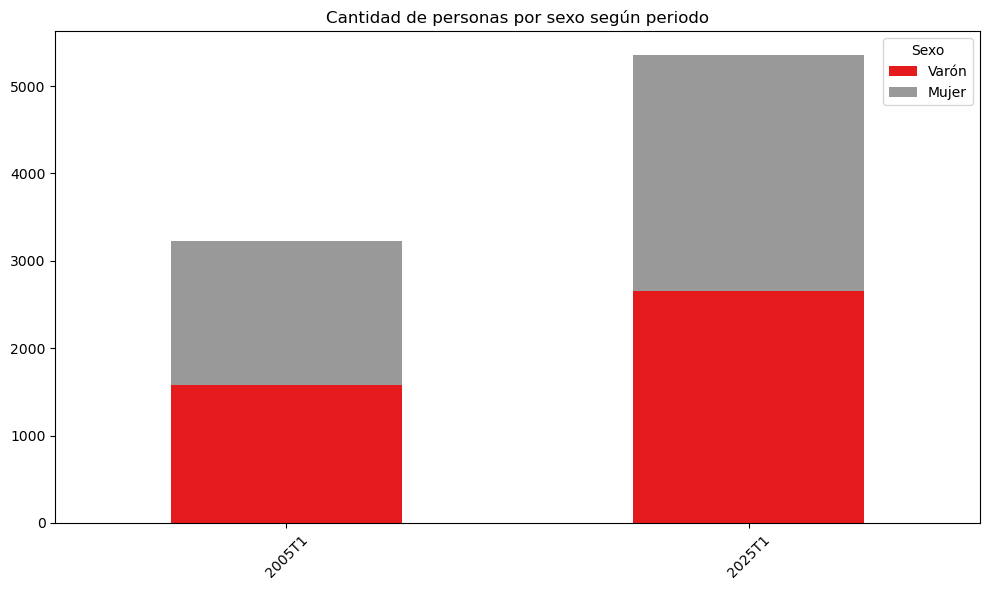

In [ ]:
# Parte 2 | Juan

# 1. Contar cantidad de registros por combinación PERIODO y CH04
tabla = df_individuos.groupby(['PERIODO', 'CH04']).size().unstack()

# 2. Renombrar columnas para mayor claridad
tabla.columns = ['Varón', 'Mujer']  # si CH04 = 1 y 2

# 3. Graficar barras apiladas
tabla.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set1')

plt.title('Cantidad de personas por sexo según periodo')
plt.ylabel('')
plt.xlabel('')
plt.legend(title='Sexo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
#Matriz de correlacion para las variables solicitadas
variables_categoricas = ['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC']

# Generar dummies
df_individuos_dummies = pd.get_dummies(df_individuos, columns=variables_categoricas, prefix_sep='_', drop_first=False)


In [10]:
df_individuos_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8588 entries, 0 to 8587
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      8588 non-null   object 
 1   NRO_HOGAR   8588 non-null   int64  
 2   COMPONENTE  8588 non-null   int64  
 3   H15         8588 non-null   int64  
 4   ANO4        8588 non-null   int64  
 5   TRIMESTRE   8588 non-null   int64  
 6   REGION      8588 non-null   int64  
 7   PONDERA     8588 non-null   int64  
 8   CH06        8588 non-null   int64  
 9   IPCF        8588 non-null   float64
 10  CH15        8588 non-null   int64  
 11  PP02H       8588 non-null   int64  
 12  PP02I       8588 non-null   int64  
 13  PP10A       224 non-null    float64
 14  T_VI        8588 non-null   int64  
 15  ITF         8588 non-null   int64  
 16  PP02E       8588 non-null   int64  
 17  PERIODO     8588 non-null   object 
 18  CH04_1      8588 non-null   bool   
 19  CH04_2      8588 non-null  

In [ ]:
# (Opcional) asegurar que estén en tipo numérico
df_individuos_dummies['CH06'] = pd.to_numeric(df_individuos_dummies['CH06'], errors='coerce')
df_individuos_dummies['IPCF'] = pd.to_numeric(df_individuos_dummies['IPCF'], errors='coerce')

In [23]:
etiquetas = {
    # CH04
    'CH04_1': 'Sexo:Varón',
    'CH04_2': 'Sexo:Mujer',

    # CH07
    'CH07_1': 'Estado:Unido',
    'CH07_2': 'Estado:Casado',
    'CH07_3': 'Estado:Separado',
    'CH07_4': 'Estado:Viudo',
    'CH07_5': 'Estado:Soltero',

    # CH08
    'CH08_1': 'Cobertura:Obra.S',
    'CH08_2': 'Cobertura:Mut/Pre',
    'CH08_3': 'Cobertura:P.Publico',
    'CH08_4': 'Cobertura:No tiene',
    'CH08_9': 'Cobertura:Ns/Nr',
    'CH08_12': 'Cobertura:Obra.S y Pre',
    'CH08_13': 'Cobertura:Obra.S y P.Público',
    'CH08_23': 'Cobertura:Pre y P.Público',
    'CH08_123': 'Cobertura:Obra.S, Pre y P.Público',

    # NIVEL_ED
    'NIVEL_ED_1': 'Estudio:Pri. incompleto',
    'NIVEL_ED_2': 'Estudio:Pri. completo',
    'NIVEL_ED_3': 'Estudio:Sec. incompleto',
    'NIVEL_ED_4': 'Estudio:Sec. completo',
    'NIVEL_ED_5': 'Estudio:Sup. incompleto',
    'NIVEL_ED_6': 'Estudio:Sup. completo',
    'NIVEL_ED_7': 'Estudio:Sin instrucción',
    'NIVEL_ED_9': 'Estudio:Ns/Nr',

    # ESTADO
    'ESTADO_0': 'Actividad:Sin entrevista',
    'ESTADO_1': 'Actividad:Ocupado',
    'ESTADO_2': 'Actividad:Desocupado',
    'ESTADO_3': 'Actividad:Inactivo',
    'ESTADO_4': 'Actividad:Menor de 10',

    # CAT_INAC
    'CAT_INAC_1': 'Cat. Inactivo:Jubilado',
    'CAT_INAC_2': 'Cat.Inactivo:Rentista',
    'CAT_INAC_3': 'Cat.Inactivo:Estudiante',
    'CAT_INAC_4': 'Cat.Inactivo:Ama de casa',
    'CAT_INAC_5': 'Cat.Inactivo:Menor de 6',
    'CAT_INAC_6': 'Cat.Inactivo:Disc.',
    'CAT_INAC_7': 'Cat.Inactivo:Otros',

    # Variables originales
    'CH06': 'Años cumplidos',
    'IPCF': 'Ingreso familiar p/c',
}


In [ ]:
# Seleccionar dummies y variables numericas a utilizar

columnas_dummies = [col for col in df_individuos_dummies.columns
                    if col.startswith(('CH04_', 'CH07_', 'CH08_', 'NIVEL_ED_', 'ESTADO_', 'CAT_INAC_'))]

# Agregamos CH06 e IPCF
columnas_finales = columnas_dummies + ['CH06', 'IPCF']

# Creamos el DataFrame filtrado
df_corr = df_individuos_dummies[columnas_finales]



In [27]:
# Aseguramos que todos los nombres estén mapeados
cols_actuales = df_corr.columns
cols_renombradas = [etiquetas.get(col, col) for col in cols_actuales]

# Asignamos los nuevos nombres
df_corr.columns = cols_renombradas
corr_matrix = df_corr.corr()


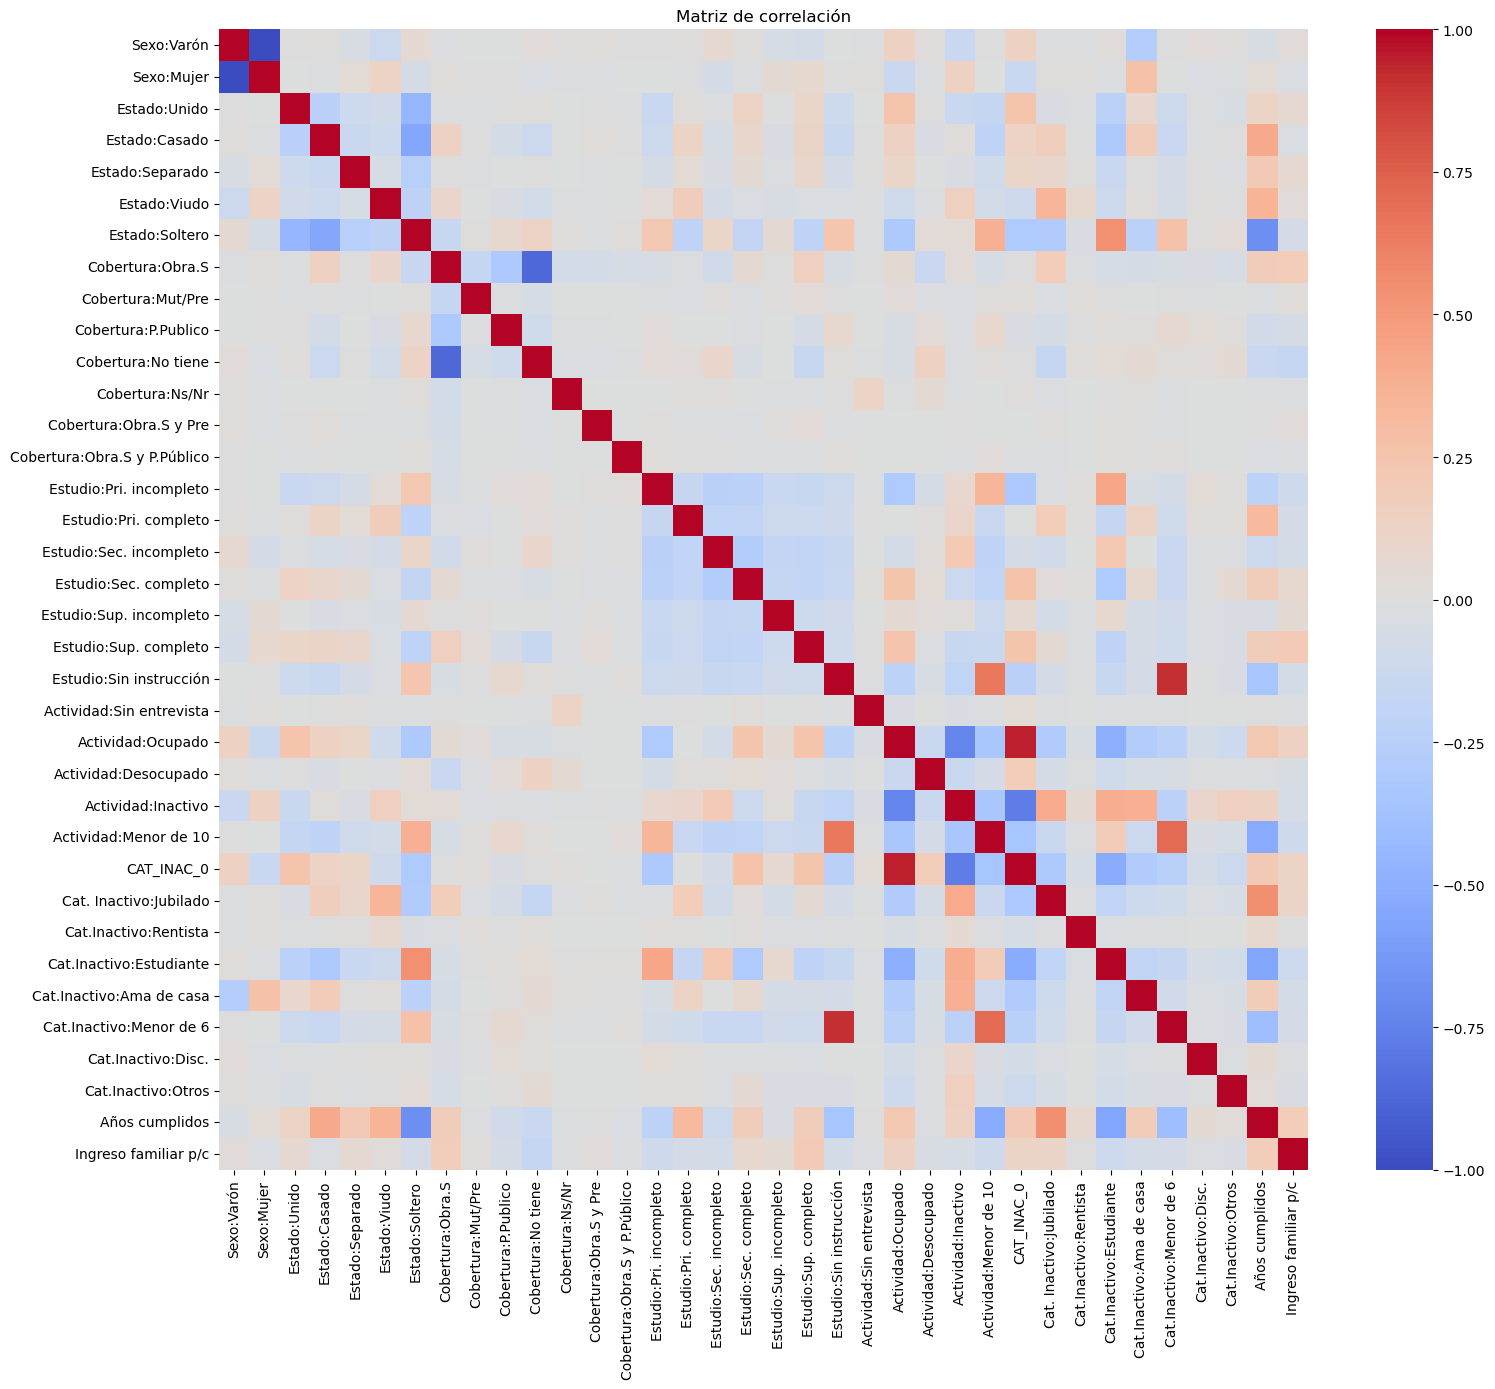

In [ ]:
#grafico la matriz de correlacion con heatmap

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)

plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()


## Parte III

In [5]:
df_individuos = pd.read_excel(r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP1\basei_unida.xlsx")
df_hogares = pd.read_excel(r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP1\hogar_unida.xlsx")



In [6]:
#-- Consigna 5 --

# Cantidad de registros que no respondieron pregunta de ingreso familiar (ITF = 0)

print(df_individuos['ITF'].eq(0).value_counts())

# Se crean dos bases con observaciones que respondieron o no la pregunta de ingreso familiar
df_respondieron = df_individuos[df_individuos['ITF'].ne(0)]
df_no_respondieron = df_individuos[df_individuos['ITF'].eq(0)]

ITF
False    7363
True     1225
Name: count, dtype: int64


In [7]:
# Cantidad de registros que respondieron o no por año
conteo_por_año = df_individuos.groupby('ANO4')['ITF'].agg(
    Respondieron=lambda x: (x != 0).sum(),
    No_respondieron=lambda x: (x == 0).sum()
)

# Total de registros
conteo_por_año['Total_Registros'] = conteo_por_año['Respondieron'] + conteo_por_año['No_respondieron']

# Cantidad de hogares que respondieron o no por año
hogares_por_año = df_individuos.groupby(['ANO4','CODUSU'])['ITF'].agg(
    respondio=lambda x: (x != 0).any()
).reset_index()

conteo_hogares = hogares_por_año.groupby('ANO4')['respondio'].agg(
    Hogares_Respondieron=lambda x: x.sum(),
    Hogares_No_Respondieron=lambda x: (~x).sum()
)

# Total de hogares
conteo_hogares['Total_Hogares'] = conteo_hogares['Hogares_Respondieron'] + conteo_hogares['Hogares_No_Respondieron']

# Unir ambos conteos en un mismo DataFrame
conteo_por_año = conteo_por_año.join(conteo_hogares)

print(conteo_por_año)

del conteo_por_año, conteo_hogares, hogares_por_año



      Respondieron  No_respondieron  Total_Registros  Hogares_Respondieron  \
ANO4                                                                         
2005          3206               23             3229                   938   
2025          4157             1202             5359                  1661   

      Hogares_No_Respondieron  Total_Hogares  
ANO4                                          
2005                       11            949  
2025                      422           2083  


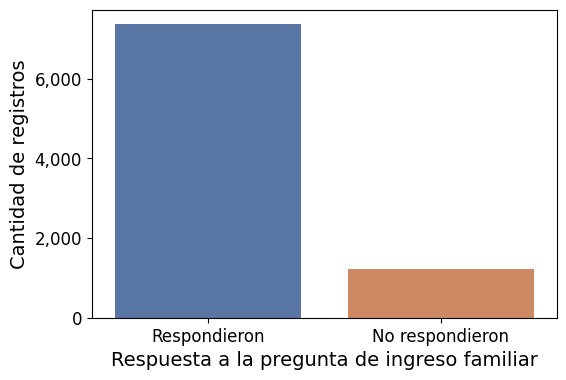

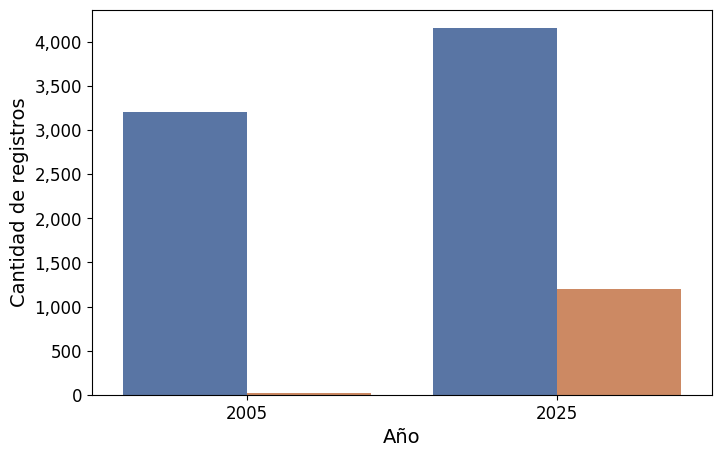

In [8]:
# Gráfico de barras para comparar cantidad de registros que respondieron y no respondieron ITF, sin segmentar por año

# Preparar DataFrame
df_plot = pd.DataFrame({
    'Respuesta': ['Respondieron', 'No respondieron'],
    'Cantidad': [df_individuos['ITF'].ne(0).sum(),
                 df_individuos['ITF'].eq(0).sum()]
})

plt.figure(figsize=(6,4))
sns.barplot(data=df_plot, x='Respuesta', y='Cantidad', hue='Respuesta', dodge=False, palette=['#4c72b0', '#dd8452'])
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xlabel('Respuesta a la pregunta de ingreso familiar', fontsize=14)
#plt.title('Cantidad de registros que respondieron y no respondieron ITF', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Quitar la leyenda duplicada
plt.legend([],[], frameon=False)

# Separador de miles en eje y
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

# Gráfico de barras apiladas para comparar cantidad de registros que respondieron y no respondieron ITF, segmentado por año

# Preparar DataFrame con conteos por año
df_plot = df_individuos.groupby('ANO4')['ITF'].agg(
    Respondieron=lambda x: (x != 0).sum(),
    No_respondieron=lambda x: (x == 0).sum()
).reset_index()

# Convertir a formato largo para usar hue
df_plot_long = df_plot.melt(id_vars='ANO4', value_vars=['Respondieron', 'No_respondieron'],
                            var_name='Respuesta', value_name='Cantidad')

plt.figure(figsize=(8,5))
sns.barplot(data=df_plot_long, x='ANO4', y='Cantidad', hue='Respuesta', dodge=True, palette=['#4c72b0', '#dd8452'])
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xlabel('Año', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.legend(title='Respuesta', fontsize=12, title_fontsize=12)
plt.legend([], [], frameon=False)


# Separador de miles en eje y
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()


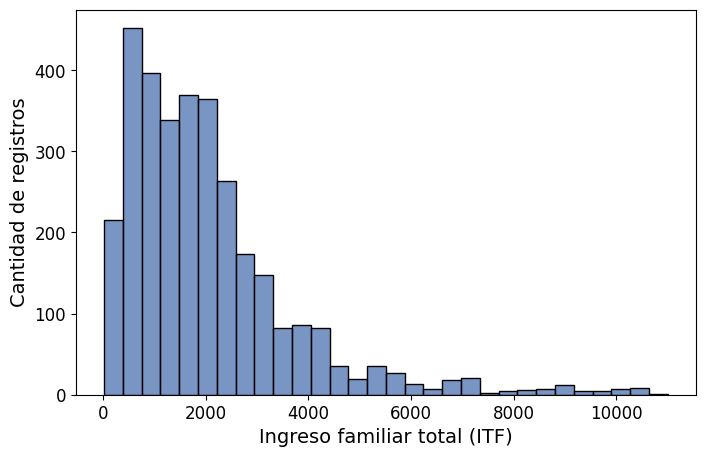

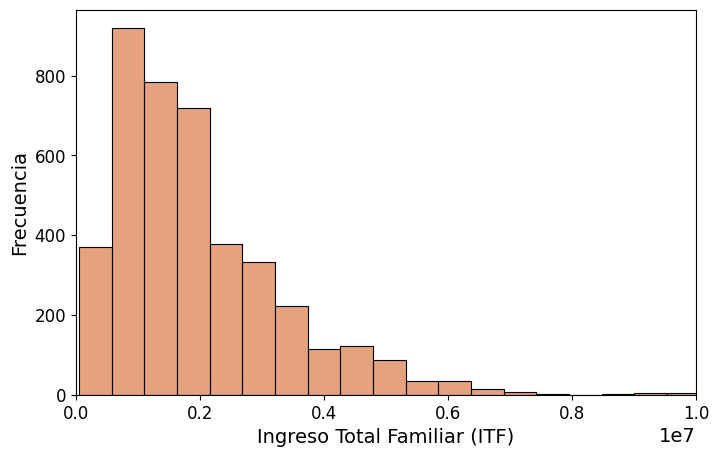

Valores fuera del rango (ITF > 10.000.000): 10 registros (0.24% del total)


In [9]:
#-----------------------------
# Histograma ITF - 2005
#-----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df_individuos[(df_individuos['ANO4']==2005) & (df_individuos['ITF']>0)]['ITF'],
             bins=30, color='#4c72b0', kde=False)
plt.xlabel('Ingreso familiar total (ITF)', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

#-----------------------------
# Histograma ITF - 2025
#-----------------------------
itf_2025 = df_individuos.query("ANO4 == 2025 and ITF > 0")['ITF']

plt.figure(figsize=(8,5))
sns.histplot(itf_2025, bins=50, color='#dd8452', kde=False)
plt.xlabel('Ingreso Total Familiar (ITF)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 10_000_000)
plt.show()

# Calcular cuántos valores quedaron fuera del gráfico
outliers = (itf_2025 > 10_000_000).sum()
total = len(itf_2025)
print(f"Valores fuera del rango (ITF > 10.000.000): {outliers} registros ({outliers/total:.2%} del total)")

del itf_2025, outliers, total


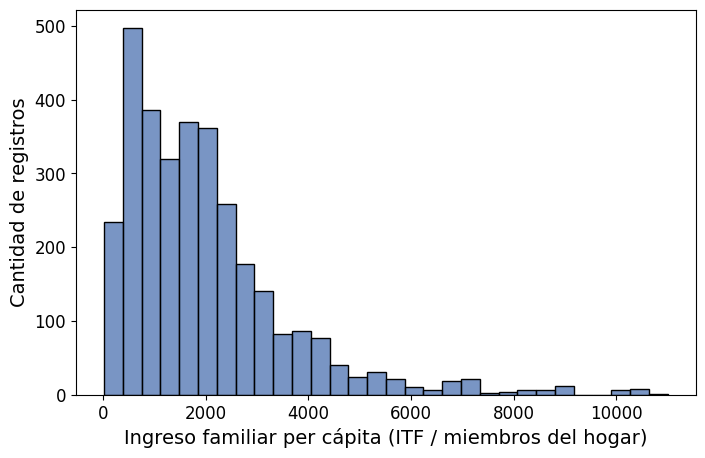

Valores per cápita fuera del rango (>10.000.000): 10 registros (0.24% del total)


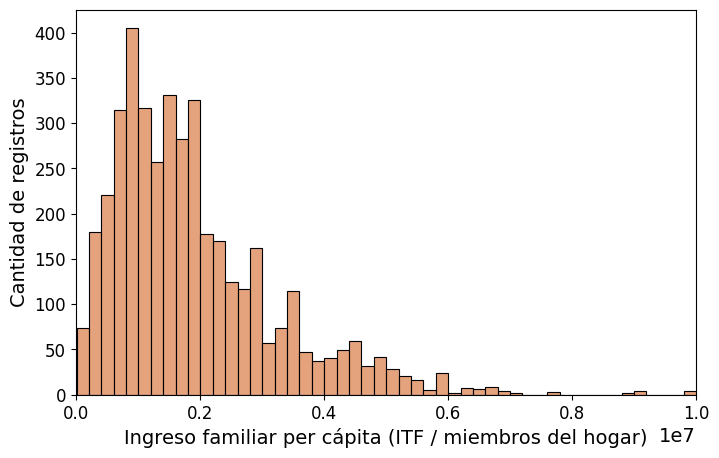

In [10]:
# Histogramas ITF per cápita (ITF / NRO_HOGAR) para 2005 y 2025
#-----------------------------
# Histograma ITF per cápita - 2005
#-----------------------------
itf_2005_pc = df_individuos[(df_individuos['ANO4']==2005) & (df_individuos['ITF']>0)]
itf_2005_pc = itf_2005_pc['ITF'] / itf_2005_pc['NRO_HOGAR']

plt.figure(figsize=(8,5))
sns.histplot(itf_2005_pc, bins=30, color='#4c72b0', kde=False)
plt.xlabel('Ingreso familiar per cápita (ITF / miembros del hogar)', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
#plt.title('Distribución de ITF per cápita - 2005', fontsize=14)
plt.show()

#-----------------------------
# Histograma ITF per cápita - 2025
#-----------------------------
itf_2025_pc = df_individuos.query("ANO4 == 2025 and ITF > 0")
itf_2025_pc = itf_2025_pc['ITF'] / itf_2025_pc['NRO_HOGAR']

plt.figure(figsize=(8,5))
sns.histplot(itf_2025_pc[itf_2025_pc <= 10_000_000], bins=50, color='#dd8452', kde=False)
plt.xlabel('Ingreso familiar per cápita (ITF / miembros del hogar)', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 10_000_000)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
#plt.title('Distribución de ITF per cápita - 2025', fontsize=14)

# Calcular outliers
outliers_pc = (itf_2025_pc > 10_000_000).sum()
total_pc = len(itf_2025_pc)
print(f"Valores per cápita fuera del rango (>10.000.000): {outliers_pc} registros ({outliers_pc/total_pc:.2%} del total)")

plt.show()

del itf_2005_pc, itf_2025_pc, outliers_pc, total_pc


In [11]:
# Filtrar ITF > 0 por año
itf_2005 = df_individuos[(df_individuos['ANO4']==2005) & (df_individuos['ITF']>0)]['ITF']
itf_2025 = df_individuos[(df_individuos['ANO4']==2025) & (df_individuos['ITF']>0)]['ITF']

# ITF per cápita
itf_pc_2005 = itf_2005 / df_individuos.loc[itf_2005.index, 'NRO_HOGAR']
itf_pc_2025 = itf_2025 / df_individuos.loc[itf_2025.index, 'NRO_HOGAR']

# Función para mostrar media y mediana
def resumen_stats(series, nombre):
    print(f"{nombre}:")
    print(f"  Media   = {series.mean():,.2f}")
    print(f"  Mediana = {series.median():,.2f}\n")
    print(f"  Mediana/media   = {series.median()/series.mean():,.2f}")

# Mostrar resultados
resumen_stats(itf_2005, "ITF 2005")
resumen_stats(itf_2025, "ITF 2025")
resumen_stats(itf_pc_2005, "ITF per cápita 2005")
resumen_stats(itf_pc_2025, "ITF per cápita 2025")

# Limpiar variables
del itf_2005, itf_2025, itf_pc_2005, itf_pc_2025, resumen_stats


ITF 2005:
  Media   = 2,033.66
  Mediana = 1,600.00

  Mediana/media   = 0.79
ITF 2025:
  Media   = 1,998,688.13
  Mediana = 1,650,000.00

  Mediana/media   = 0.83
ITF per cápita 2005:
  Media   = 1,977.40
  Mediana = 1,593.00

  Mediana/media   = 0.81
ITF per cápita 2025:
  Media   = 1,970,311.51
  Mediana = 1,600,000.00

  Mediana/media   = 0.81


In [12]:
#-- Consigna 6 --

# Importar solo el rango relevante
tabla_equiv = pd.read_excel(r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP1\tabla_adulto_equiv.xlsx",
    header=3,          # fila 4 (Python indexa desde 0)
    usecols="A:C",     # columnas A a C
    skiprows=lambda x: x < 5 or x > 27  # mantener filas 6 a 28 (excluye encabezados adicionales)
)


In [13]:
print(tabla_equiv)

            3 años  0.51  0.51.1
0           4 años  0.55    0.55
1           5 años  0.60    0.60
2           6 años  0.64    0.64
3           7 años  0.66    0.66
4           8 años  0.68    0.68
5           9 años  0.69    0.69
6          10 años  0.70    0.79
7          11 años  0.72    0.82
8          12 años  0.74    0.85
9          13 años  0.76    0.90
10         14 años  0.76    0.96
11         15 años  0.77    1.00
12         16 años  0.77    1.03
13         17 años  0.77    1.04
14    18 a 29 años  0.76    1.02
15    30 a 45 años  0.77    1.00
16    46 a 60 años  0.76    1.00
17    61 a 75 años  0.67    0.83
18  más de 75 años  0.63    0.74


In [14]:
df_individuos = df_individuos.assign(
    adult_eq = np.select(
        [
            df_individuos.CH06 < 1,
            df_individuos.CH06 == 1,
            df_individuos.CH06 == 2,
            df_individuos.CH06 == 3,
            df_individuos.CH06 == 4,
            df_individuos.CH06 == 5,
            df_individuos.CH06 == 6,
            df_individuos.CH06 == 7,
            df_individuos.CH06 == 8,
            df_individuos.CH06 == 9,
            df_individuos.CH06 == 10,
            df_individuos.CH06 == 11,
            df_individuos.CH06 == 12,
            df_individuos.CH06 == 13,
            df_individuos.CH06 == 14,
            df_individuos.CH06 == 15,
            df_individuos.CH06 == 16,
            df_individuos.CH06 == 17,
            df_individuos.CH06.between(18,29),
            df_individuos.CH06.between(30,45),
            df_individuos.CH06.between(46,60),
            df_individuos.CH06.between(61,75),
            df_individuos.CH06 > 75
        ],
        [
            0.35,
            0.37,
            0.46,
            0.51,
            0.55,
            0.60,
            0.64,
            0.66,
            0.68,
            0.69,
            np.where(df_individuos.CH04==1,0.79,0.70),
            np.where(df_individuos.CH04==1,0.82,0.72),
            np.where(df_individuos.CH04==1,0.85,0.74),
            np.where(df_individuos.CH04==1,0.90,0.76),
            np.where(df_individuos.CH04==1,0.96,0.76),
            np.where(df_individuos.CH04==1,1.00,0.77),
            np.where(df_individuos.CH04==1,1.03,0.77),
            np.where(df_individuos.CH04==1,1.04,0.77),
            np.where(df_individuos.CH04==1,1.02,0.76),
            1.00,
            np.where(df_individuos.CH04==1,1.00,0.76),
            np.where(df_individuos.CH04==1,0.83,0.67),
            np.where(df_individuos.CH04==1,0.74,0.63)
        ],
        default=np.nan
    )
)

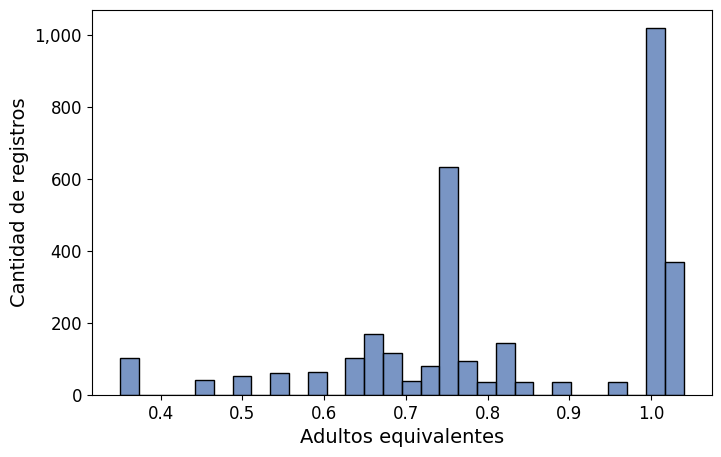

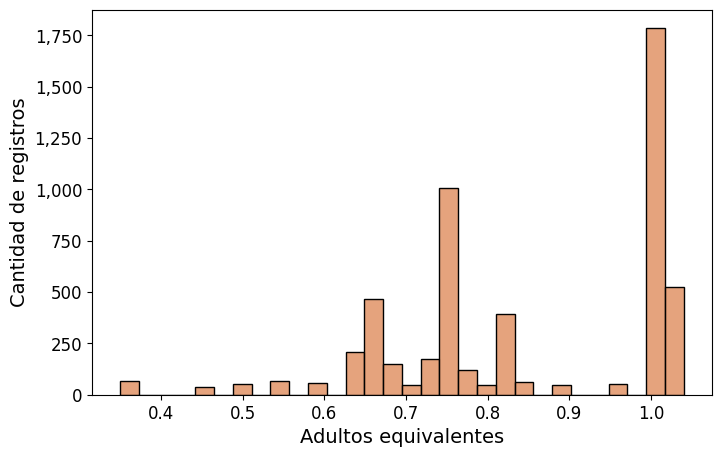

In [16]:
# Histograma para el año 2005
plt.figure(figsize=(8,5))
sns.histplot(df_individuos[df_individuos['ANO4']==2005]['adult_eq'], 
             bins=30, color='#4c72b0', kde=False)
plt.xlabel('Adultos equivalentes', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
#plt.title('Distribución de adultos equivalentes - 2005', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

# Histograma para el año 2025
plt.figure(figsize=(8,5))
sns.histplot(df_individuos[df_individuos['ANO4']==2025]['adult_eq'], 
             bins=30, color='#dd8452', kde=False)
plt.xlabel('Adultos equivalentes', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
#plt.title('Distribución de adultos equivalentes - 2025', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()


In [18]:
df_individuos['ad_equiv_hogar'] = df_individuos.groupby('CODUSU')['adult_eq'].transform('sum')

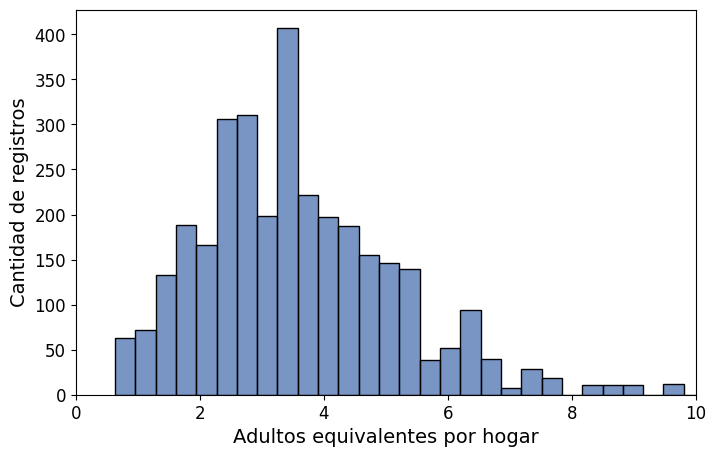

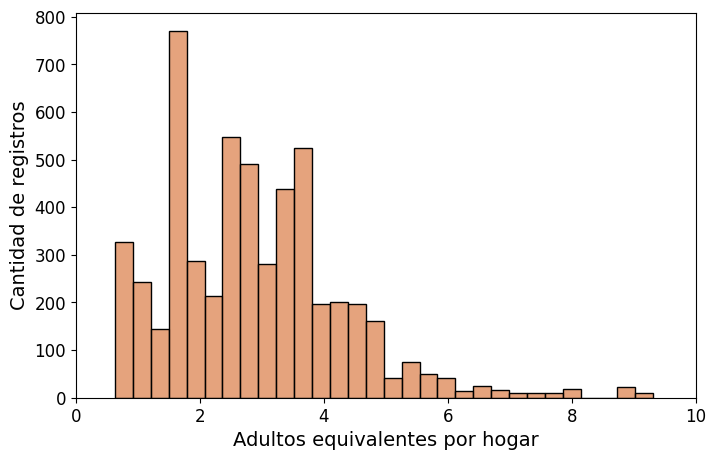

In [19]:
# Histograma para el año 2005
plt.figure(figsize=(8,5))
sns.histplot(df_individuos[df_individuos['ANO4']==2005]['ad_equiv_hogar'], 
             bins=30, color='#4c72b0', kde=False)
plt.xlabel('Adultos equivalentes por hogar', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 10)  # Eje x de 0 a 10
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

# Histograma para el año 2025
plt.figure(figsize=(8,5))
sns.histplot(df_individuos[df_individuos['ANO4']==2025]['ad_equiv_hogar'], 
             bins=30, color='#dd8452', kde=False)
plt.xlabel('Adultos equivalentes por hogar', fontsize=14)
plt.ylabel('Cantidad de registros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 10)  # Eje x de 0 a 10
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()


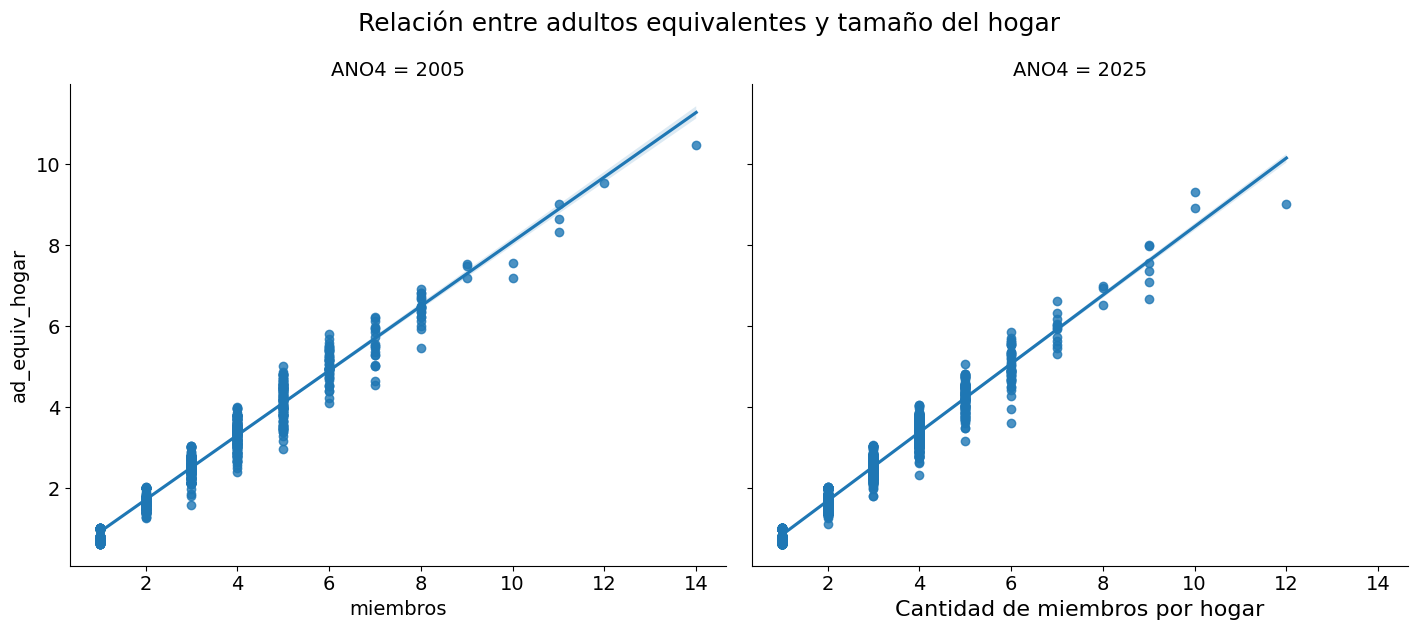

In [22]:

sns.lmplot(
    data=df_individuos.groupby(['CODUSU','ANO4']).agg(
        miembros=('CODUSU','count'),
        ad_equiv_hogar=('ad_equiv_hogar','first')
    ).reset_index(),
    x='miembros',
    y='ad_equiv_hogar',
    col='ANO4',   # crea un panel por año
    height=6,
    aspect=1.2
)

# Aumentar tamaño de labels y title
plt.xlabel('Cantidad de miembros por hogar', fontsize=16)
plt.ylabel('Adultos equivalentes por hogar', fontsize=16)
plt.suptitle('Relación entre adultos equivalentes y tamaño del hogar', fontsize=18, y=1.05)

plt.show()



In [23]:


# Selección directa de los valores
val_2005 = df_individuos[df_individuos['ANO4']==2005].groupby('CODUSU')['ad_equiv_hogar'].first()
val_2025 = df_individuos[df_individuos['ANO4']==2025].groupby('CODUSU')['ad_equiv_hogar'].first()

# Test t de muestras independientes
t_stat, p_val = ttest_ind(val_2005, val_2025, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.3f}")

del val_2005, val_2025, t_stat, p_val

# este código indica si cambió el promedio de adultos equivalentes por hogar entre 2005 y 2025, sin diferenciar por tamaño de hogar.



t = 11.946, p = 0.000


In [24]:
from scipy.stats import ttest_ind

tamanos = sorted(df_individuos.groupby('CODUSU').size().unique())

for miembros in tamanos:
    val_2005 = df_individuos[(df_individuos['ANO4']==2005) &
                             (df_individuos.groupby('CODUSU')['CODUSU'].transform('count')==miembros)].groupby('CODUSU')['ad_equiv_hogar'].first()
    
    val_2025 = df_individuos[(df_individuos['ANO4']==2025) &
                             (df_individuos.groupby('CODUSU')['CODUSU'].transform('count')==miembros)].groupby('CODUSU')['ad_equiv_hogar'].first()
    
    n_2005 = len(val_2005)
    n_2025 = len(val_2025)
    
    if n_2005 >= 2 and n_2025 >= 2:
        t_stat, p_val = ttest_ind(val_2005, val_2025, equal_var=False)
        print(f"Hogares de {miembros} miembros: t={t_stat:.3f}, p={p_val:.3f}, n_2005={n_2005}, n_2025={n_2025}")

# este código indica si cambió el promedio de adultos equivalentes por hogar entre 2005 y 2025 de acuerdo a la cantidad de miembros por hogar.


Hogares de 1 miembros: t=2.169, p=0.031, n_2005=133, n_2025=569
Hogares de 2 miembros: t=1.787, p=0.075, n_2005=192, n_2025=594
Hogares de 3 miembros: t=-1.517, p=0.130, n_2005=215, n_2025=399
Hogares de 4 miembros: t=-2.030, p=0.043, n_2005=187, n_2025=324
Hogares de 5 miembros: t=-2.239, p=0.026, n_2005=119, n_2025=124
Hogares de 6 miembros: t=0.517, p=0.606, n_2005=53, n_2025=48
Hogares de 7 miembros: t=-2.612, p=0.014, n_2005=20, n_2025=13
Hogares de 8 miembros: t=-2.507, p=0.079, n_2005=20, n_2025=3
Hogares de 9 miembros: t=-0.183, p=0.860, n_2005=3, n_2025=6
Hogares de 10 miembros: t=-6.505, p=0.023, n_2005=2, n_2025=2


In [25]:
# Consigna 7

df_respondieron = df_individuos[df_individuos['ITF'].ne(0)]
df_no_respondieron = df_individuos[df_individuos['ITF'].eq(0)]

# Asignar valores de Canasta Básica Total por año
cbt_por_año = {2005: 205.07, 2025: 365_177}

# Crear columna ingreso_necesario según el año y adultos equivalentes
df_respondieron['ingreso_necesario'] = df_respondieron.apply(
    lambda row: row['ad_equiv_hogar'] * cbt_por_año.get(row['ANO4'], 0),
    axis=1
)

# Verificar las primeras filas
df_respondieron[['ANO4', 'ad_equiv_hogar', 'ingreso_necesario']].head()

del cbt_por_año

C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_11136\3938646938.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respondieron['ingreso_necesario'] = df_respondieron.apply(


In [26]:
# Consigna 8

# Crear columna 'pobre': 1 si ITF < ingreso_necesario, 0 en caso contrario
df_respondieron['pobre'] = (df_respondieron['ITF'] < df_respondieron['ingreso_necesario']).astype(int)

# Conteo de pobres por año
conteo_pobres = df_respondieron.groupby('ANO4')['pobre'].agg(
    cantidad_pobres='sum',
    total_registros='count'
).reset_index()

# Agregar porcentaje
conteo_pobres['porcentaje'] = (conteo_pobres['cantidad_pobres'] / conteo_pobres['total_registros']) * 100

print(conteo_pobres)


   ANO4  cantidad_pobres  total_registros  porcentaje
0  2005              600             3206   18.714910
1  2025              934             4157   22.468126


C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_11136\4106571615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respondieron['pobre'] = (df_respondieron['ITF'] < df_respondieron['ingreso_necesario']).astype(int)


In [27]:
# Consigna 9 a

# Estadísticas descriptivas de 'pobre' por año
stats_pobre = df_respondieron.groupby('ANO4')['pobre'].agg(
    cantidad='count',
    total_pobres='sum',
    porcentaje_pobres=lambda x: x.mean() * 100
).reset_index()

print(stats_pobre)


   ANO4  cantidad  total_pobres  porcentaje_pobres
0  2005      3206           600          18.714910
1  2025      4157           934          22.468126


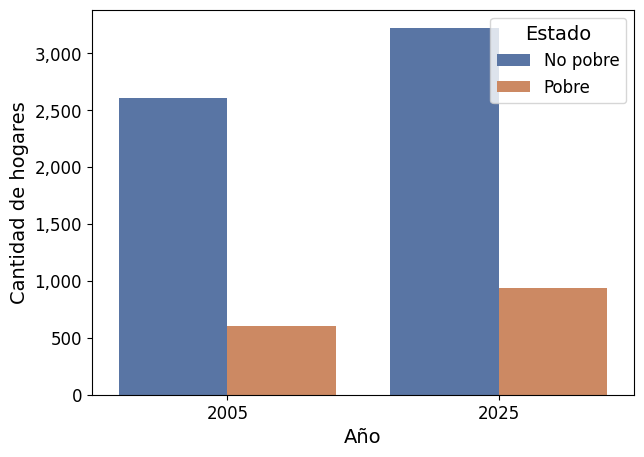

In [28]:
# Consigna 9 b

df_plot = df_respondieron.groupby(['ANO4', 'pobre']).size().reset_index(name='cantidad')
df_plot['tipo'] = df_plot['pobre'].map({1: 'Pobre', 0: 'No pobre'})

plt.figure(figsize=(7,5))
sns.barplot(data=df_plot, x='ANO4', y='cantidad', hue='tipo', palette=['#4c72b0', '#dd8452'])
plt.ylabel('Cantidad de hogares', fontsize=14)
plt.xlabel('Año', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Estado', fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()
